# ENCODE bigWig analysis questions
# Chris Simons, Vamsi Chavali, Jared Khan

Do your best to answer all parts of each question. You are encouraged to work in pairs. 

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. `hwutils.py`) so they can be commented on easily and focus the notebook on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [3]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [4]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

/tmp/ipykernel_18886/1708817607.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


# Q1
- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


/Users/ashleykasem/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


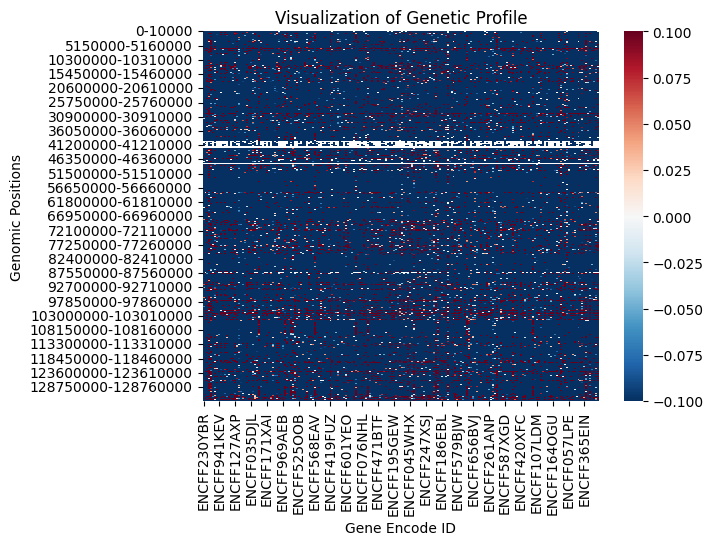

In [3]:
import seaborn as sns
df_temp=df.copy()
df_temp.index = df.iloc[:,1].astype(str) + '-' + df.iloc[:,2].astype(str)
sns.heatmap(np.log2(df_temp[df_temp.columns[3:]]), cmap='RdBu_r')
plt.xlabel('Gene Encode ID')
plt.ylabel('Genomic Positions')
plt.title('Visualization of Genetic Profile')
plt.show()

Based on the heatmap visualization, it is evident there is a dip in signal at 40MB on chr10. This most likely occurs because this region may be adjacent to a centromere. Centromeres have highly repetitive elements, thus resulting in them being very difficult to sequence which could result in the low signal observed. Additionally, centromeres are also lowly transcribed, because of this, there may not be much signal to collect anyway, resulting in the observed output.

# Q2
- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


/Users/ashleykasem/Downloads/code_review/qbio577_fall2022/hwutils.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  g=plt.scatter(pca.components_[0],


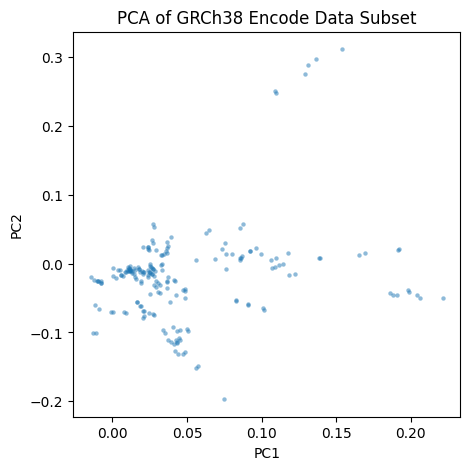

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(df.iloc[:,3:])

plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = None, alpha = 0.5, lw = 0, figsize=(5,5)) 
plt.title("PCA of GRCh38 Encode Data Subset")
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

# Q3
- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

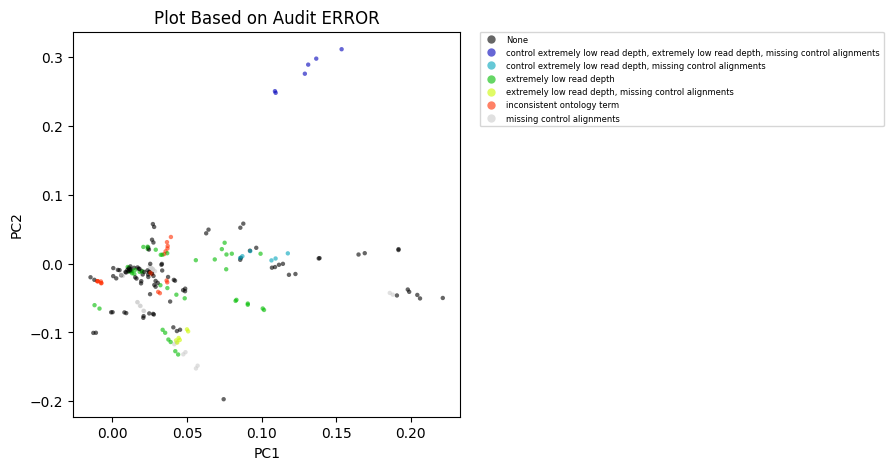

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(df.iloc[:, 3:])
#for column in bigwig_metadata.columns:
#    plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = column, alpha = 0.6, lw = 0, figsize=(5,5))
#    plt.title('Plot Based on: '+column)
#    plt.show()

plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Audit ERROR", alpha = 0.6, lw = 0, figsize=(5,5))
plt.title('Plot Based on Audit ERROR')
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

<span style="color:red">Remove all commented code out of the notebook to improve readability. The code commmented out in the previous line should be removed from notebook. </span>


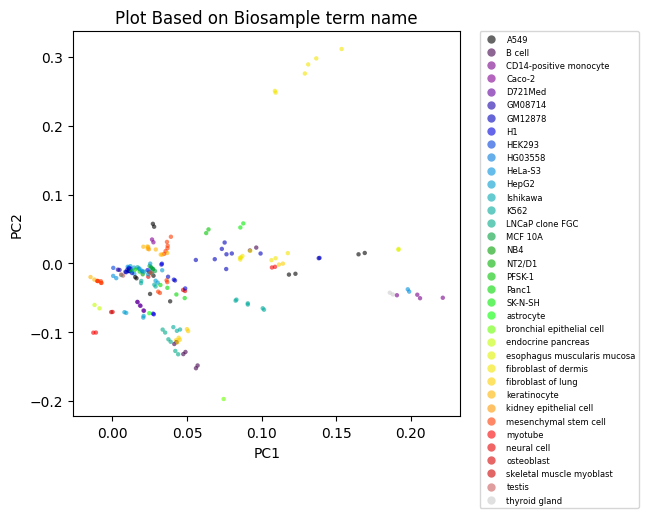

In [38]:
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Biosample term name", alpha = 0.6, lw = 0, figsize=(5,5))
plt.title('Plot Based on Biosample term name')
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

In [5]:
mask = bigwig_metadata[bigwig_metadata['Audit ERROR'] == 'None']
Filter = mask[mask['File accession'].isin(df.columns[3:])]
df = df.loc[:, df.columns.isin(Filter['File accession'])]

<span style="color:red">Changed removing of outliers to remove all data that has Audit Errors as most of these errors are pretty releavnt to the data in terms of looking at expression. Maybe not remove all of them, but y'all included way too many of the errors, which caused too many of your graphs to have too many labels which decreases readability. Moreover, it probably hid some trends that were in the data but just masked by outliers.</span>


/Users/ashleykasem/Downloads/code_review/qbio577_fall2022/hwutils.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  g=plt.scatter(pca.components_[0],


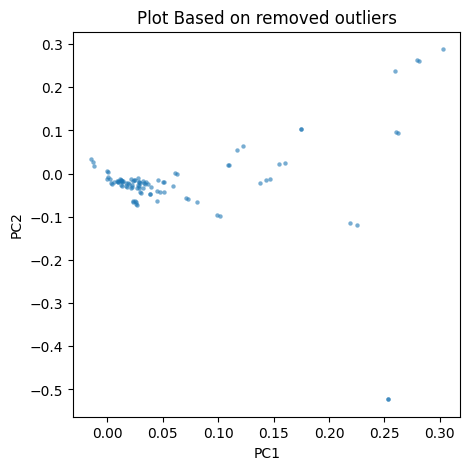

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(df.iloc[:, 3:])
plot_pca(pca, bigwig_metadata = bigwig_metadata, alpha = 0.6, lw = 0, figsize=(5,5))
plt.title('Plot Based on removed outliers')
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

We originally looked at all the different PCA separations of the metadata to identify and remove the outliers. We considered using the Biosample term name as a way to, but when looking at all the different labels, we realized using a smaller split such as Audit error would be easier. Removing the samples where the Audit Error flag reads 'control extremely low read depth, extremely low read depth, missing control alignments' will remove only the outliers, and cleans the data so the samples are all at a consistent read depth for the PCA analysis.

# Q4
- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


***Pattern recognition by assay type***

<span style="color:red">Label your axes for the autocorrelation plots otherwise it is very confusing what we are looking at. </span>


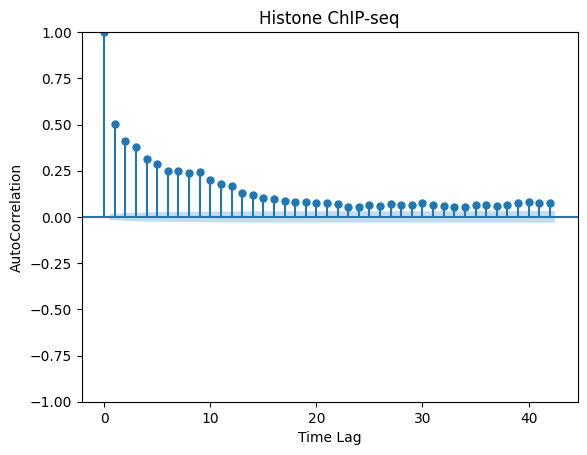

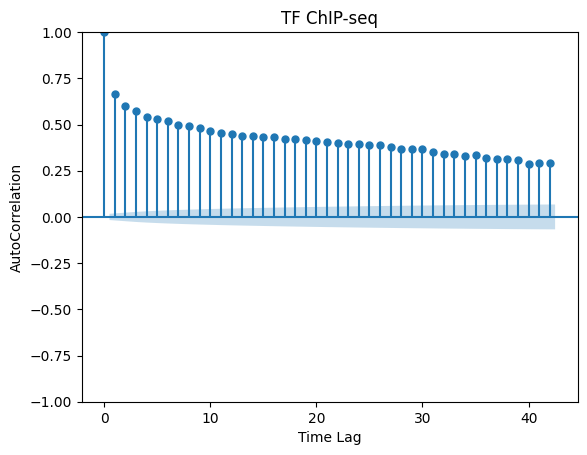

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(2):
    assay_type =  Filter[Filter['Assay']== (Filter['Assay'].unique()[i])].iloc[0, 1]
    df_assay = df.loc[:,df.columns == assay_type]
    plot_acf(df_assay)
    plt.title(Filter['Assay'].unique()[i])
    plt.xlabel('Time Lag')
    plt.ylabel("AutoCorrelation")

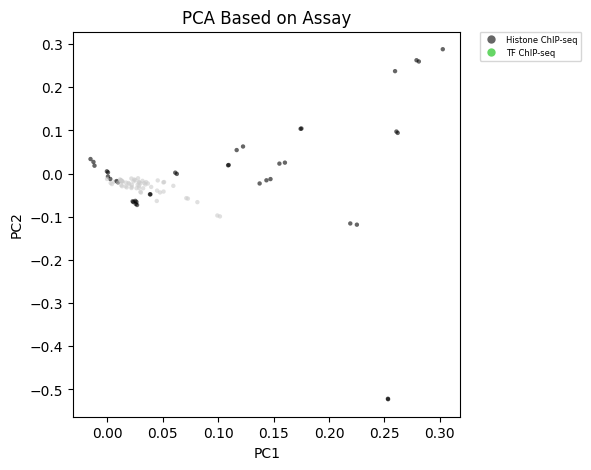

In [8]:
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Assay", alpha = 0.6, lw = 0, figsize=(5,5))
plt.title('PCA Based on Assay')
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

***Pattern recognition by experiment target***

<span style="color:red">Again label your axes on the plots and probably switch from using the raw base pair positions on the x axes to the human readable position formatter included in the notebook --> first cell has it as bp_formatter </span>


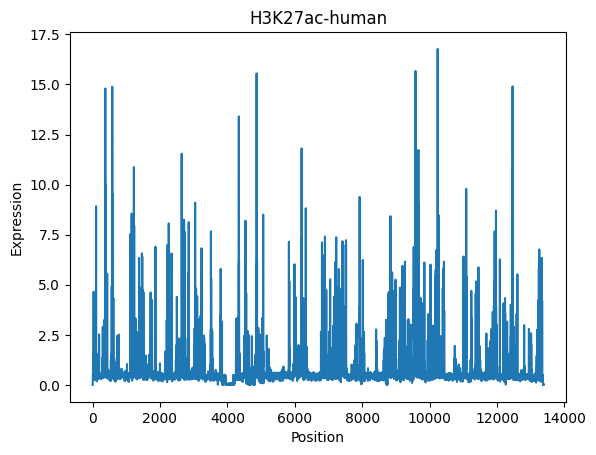

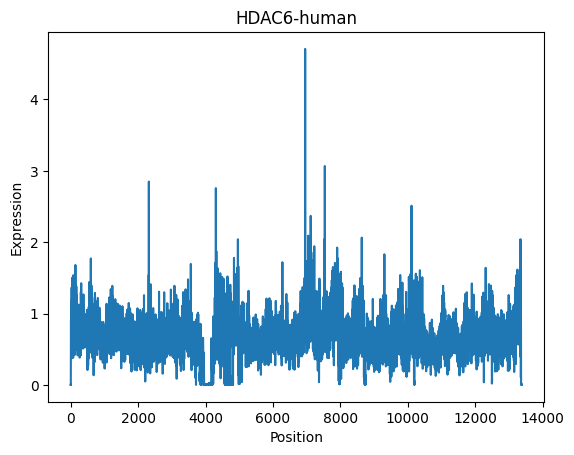

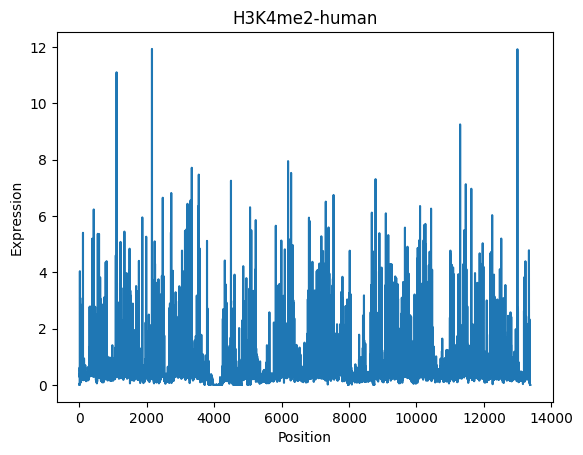

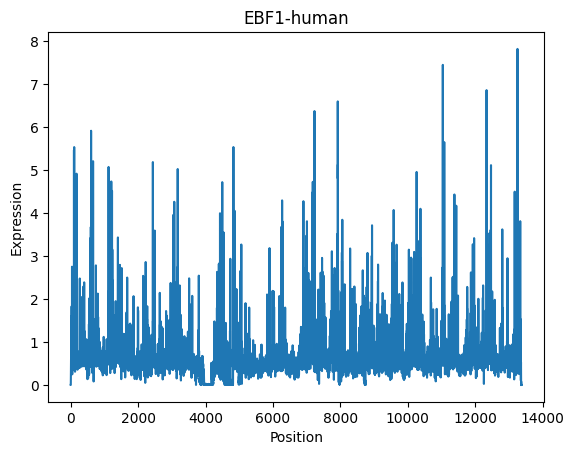

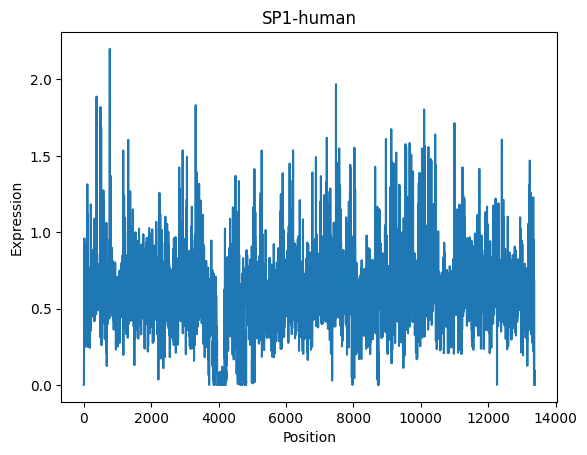

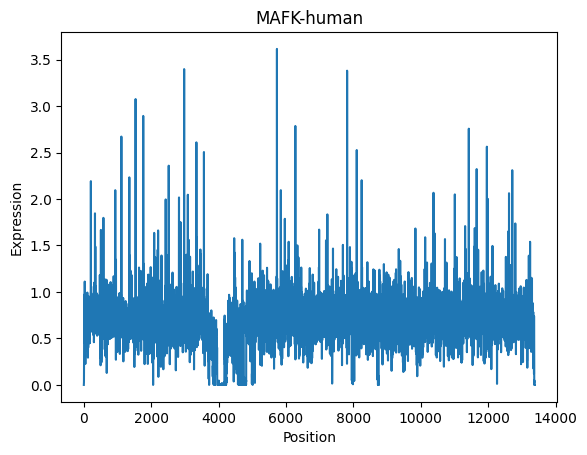

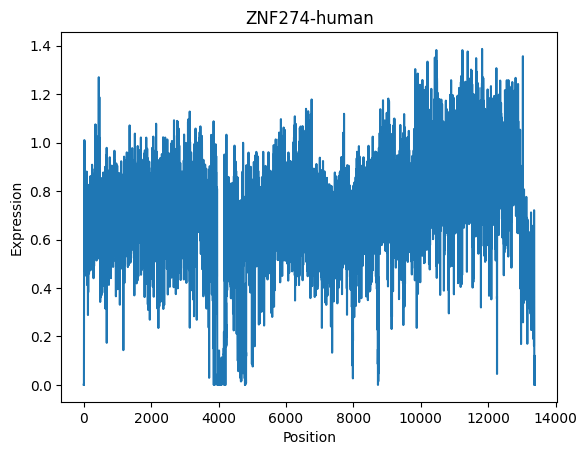

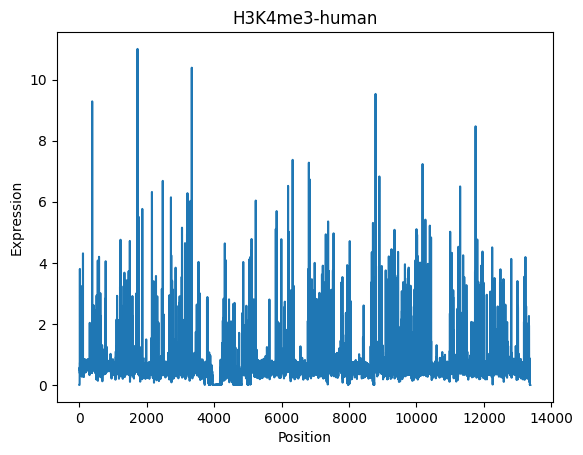

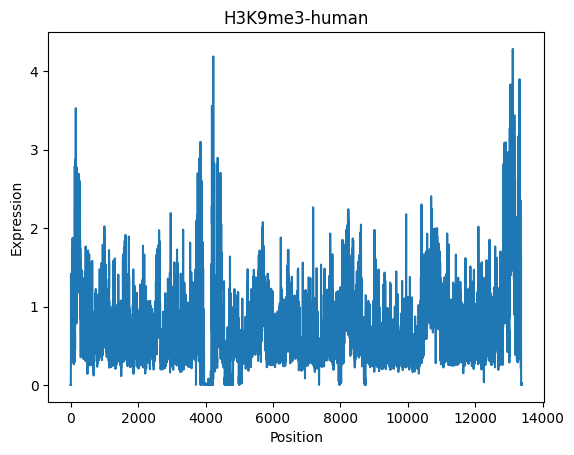

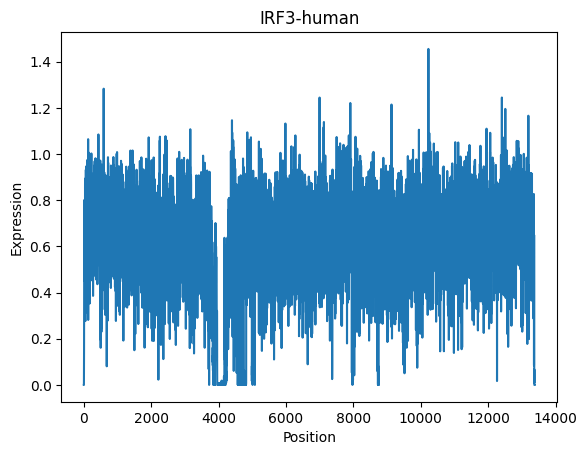

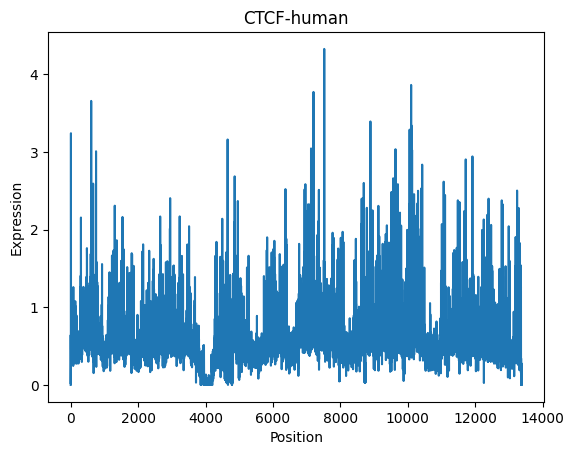

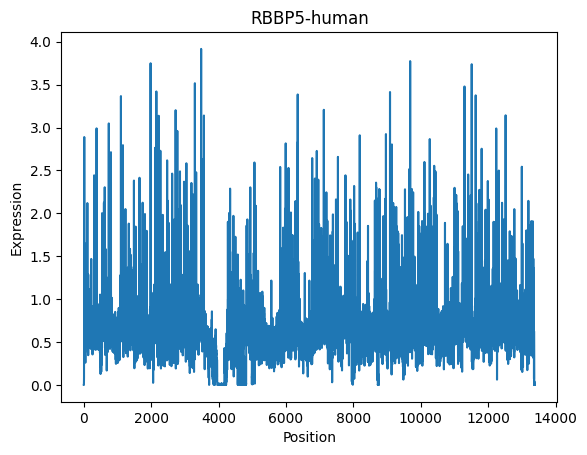

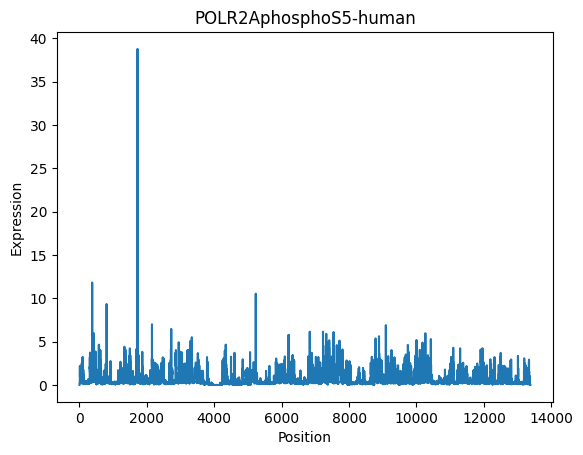

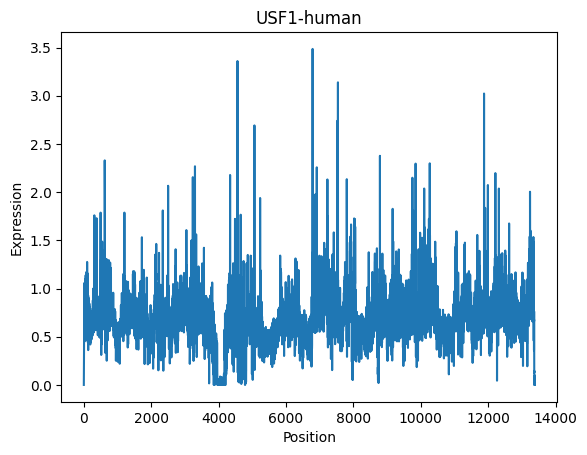

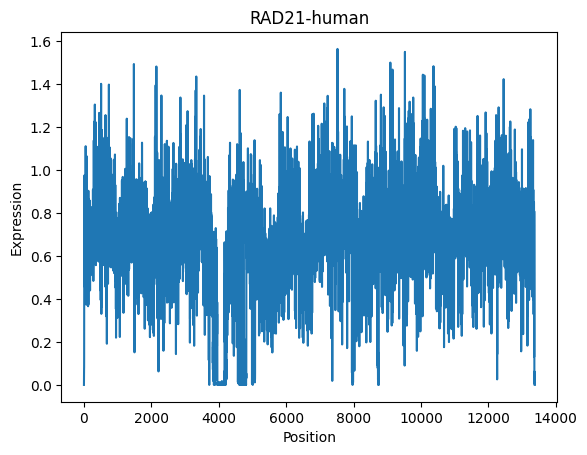

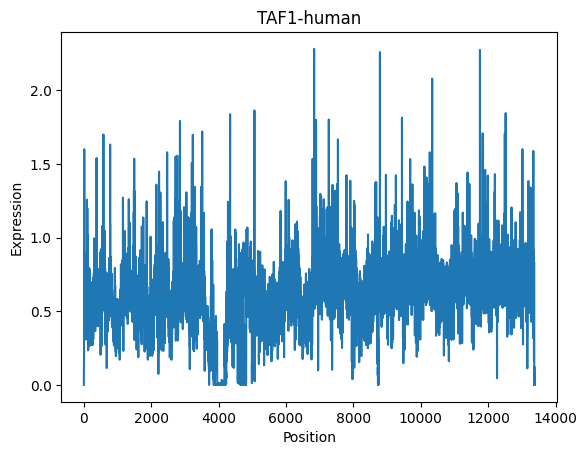

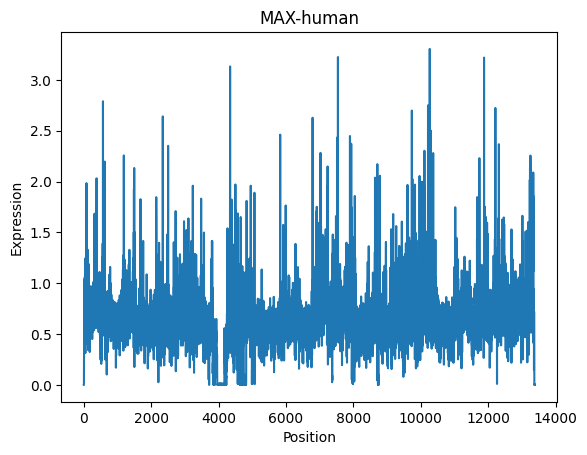

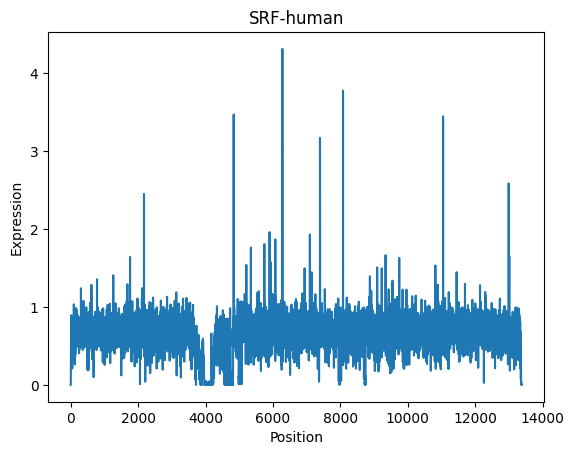

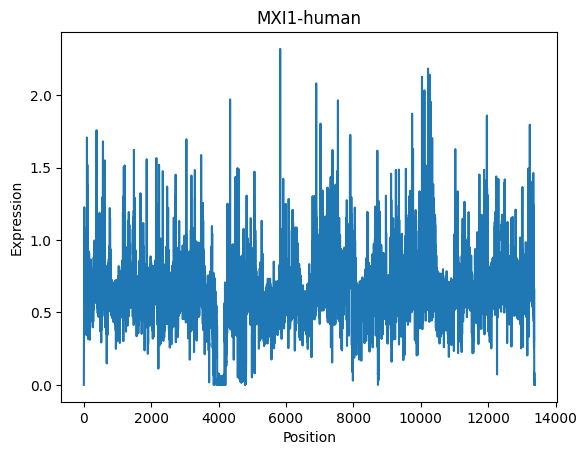

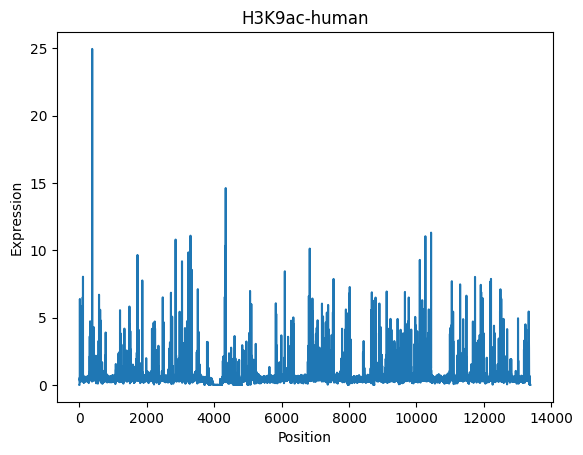

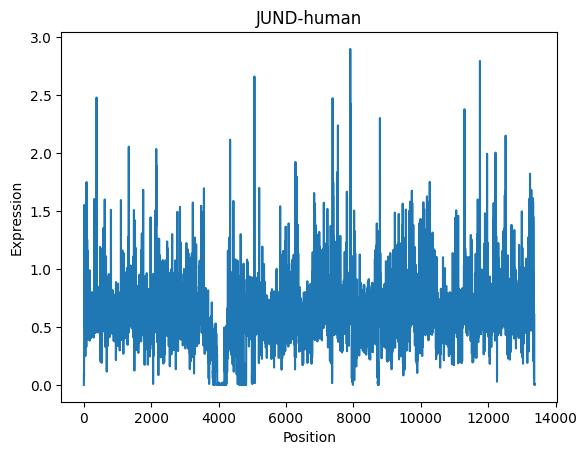

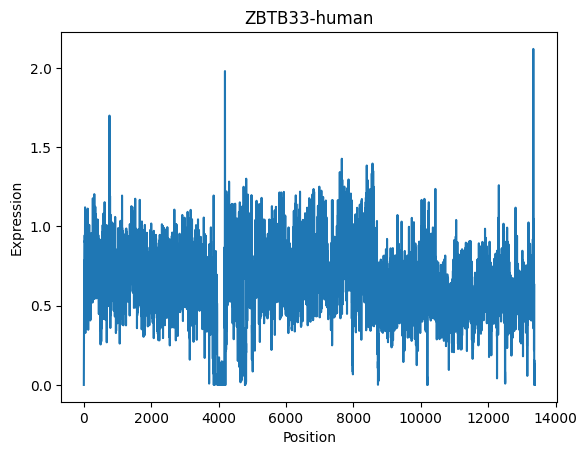

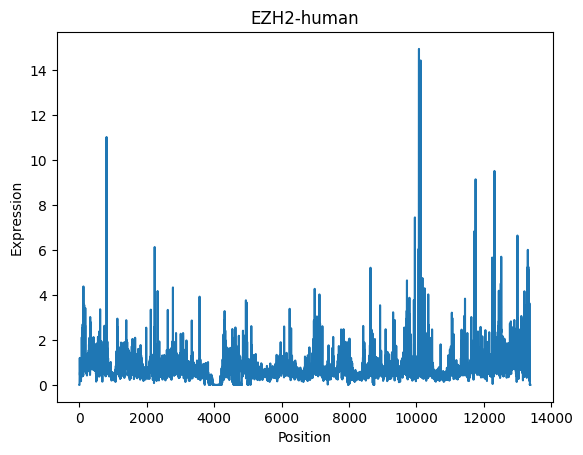

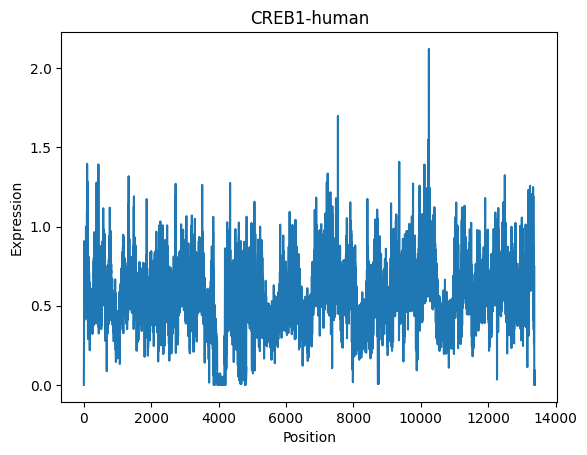

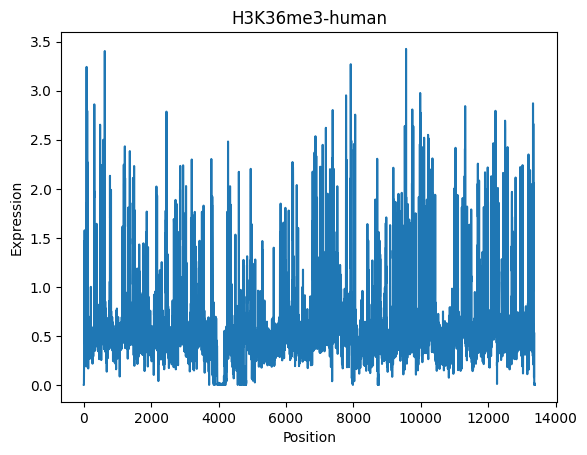

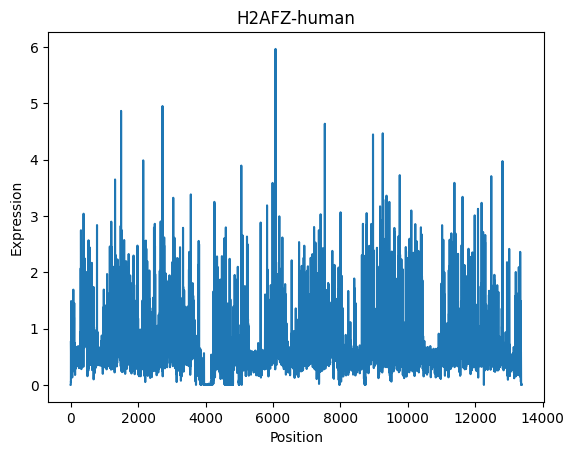

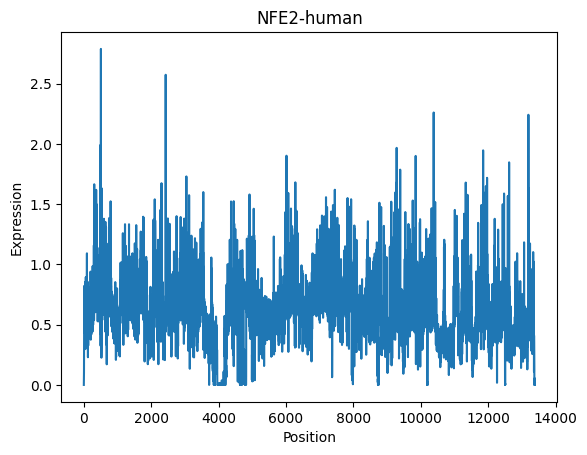

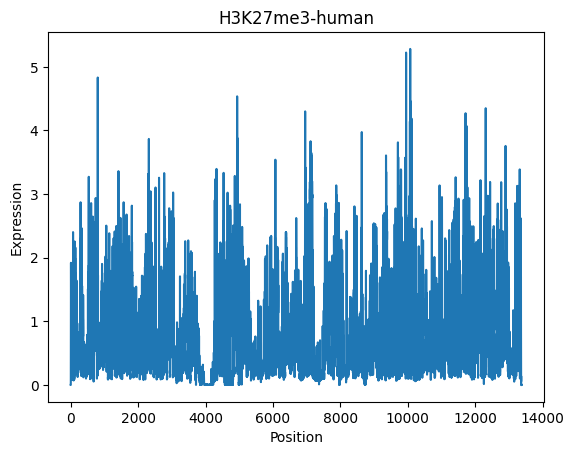

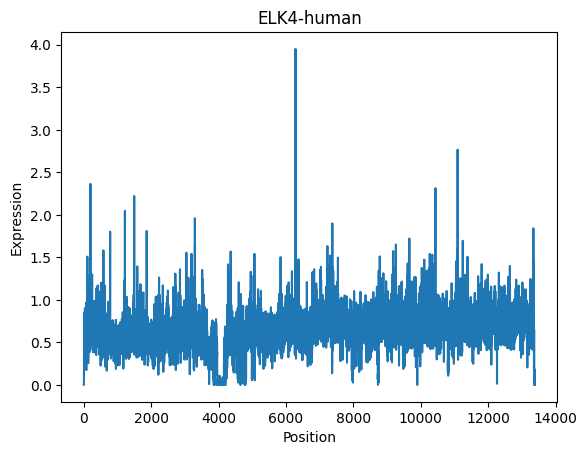

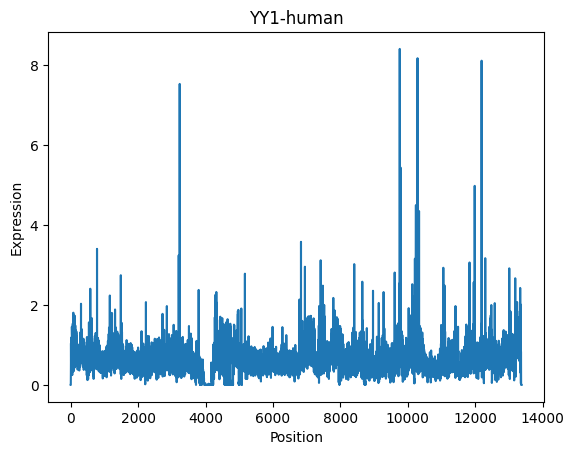

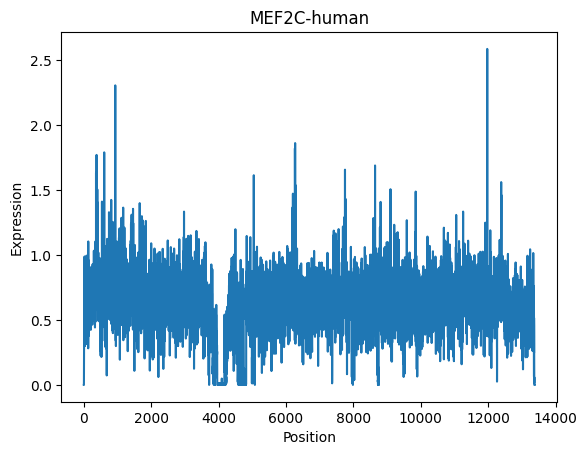

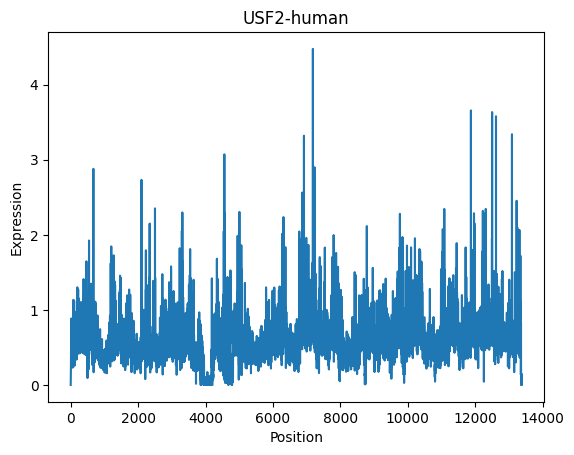

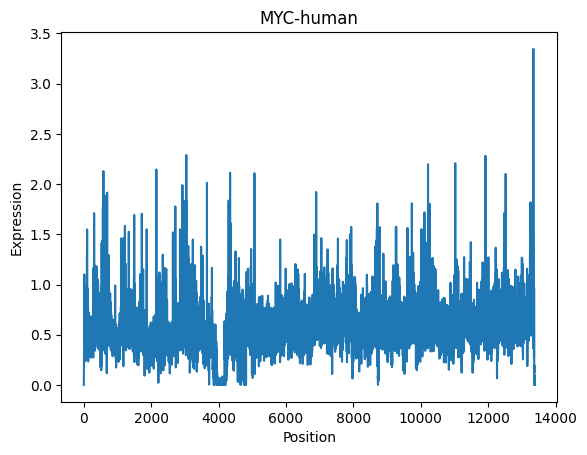

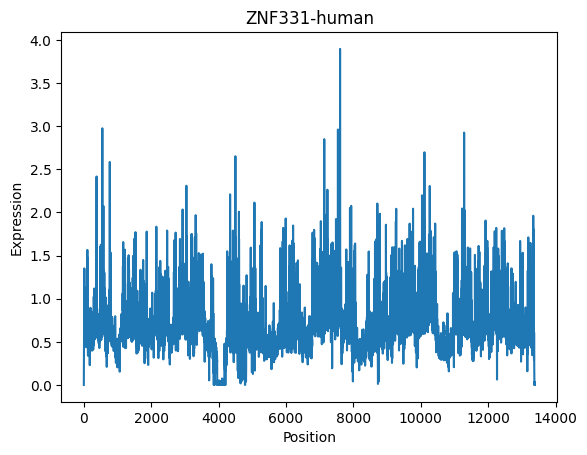

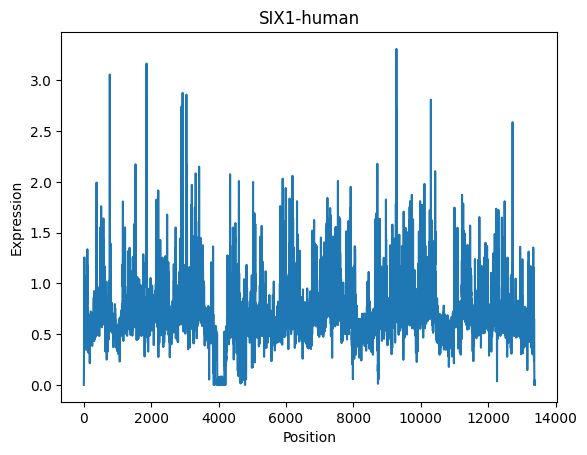

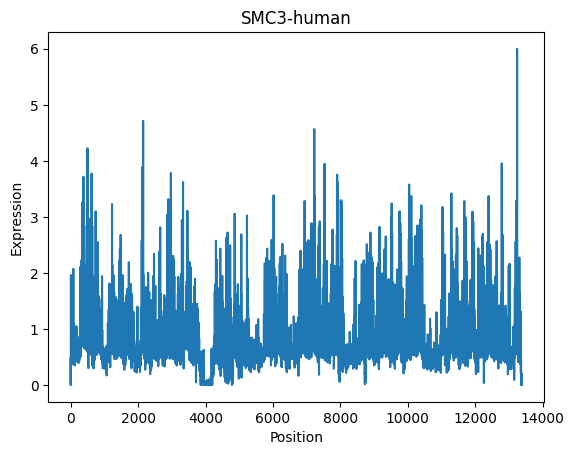

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(36):
    assay_type =  Filter[Filter['Experiment target']== (Filter['Experiment target'].unique()[i])].iloc[0, 1]
    df_assay = df.loc[:,df.columns == assay_type]
    plt.plot(df_assay)
    plt.title(Filter['Experiment target'].unique()[i])
    plt.xlabel('Position')
    plt.ylabel("Expression")
    plt.show()

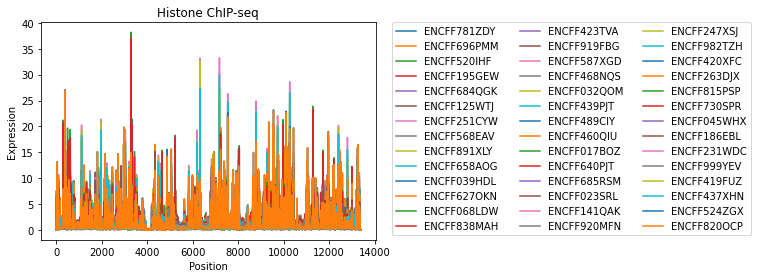

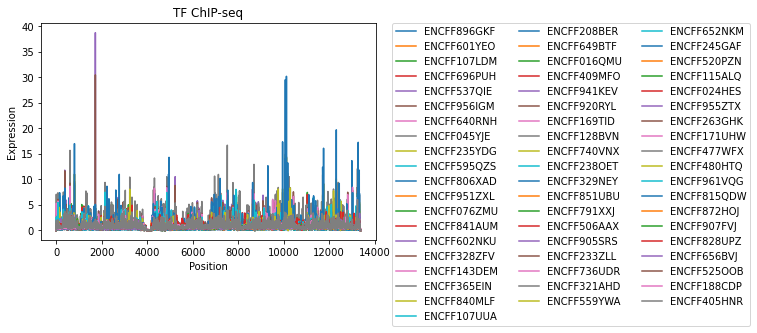

In [6]:
for i in range(2):
    assay = Filter[Filter['Assay']== (Filter['Assay'].unique()[i])].iloc[:, 1]
    splitdf = df[assay]
    splitdf.plot(legend=True)
    plt.title(Filter['Assay'].unique()[i])
    plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0,ncol=3)
    plt.xlabel('Position')
    plt.ylabel("Expression")

<span style="color:red">There is no point in plotting these expressions seperately just to color each line by each sample accession. More useful to combine the plots into one plot, and color by whether it is Histone or TF ChipSeq to see which assay has different patterns. </span>


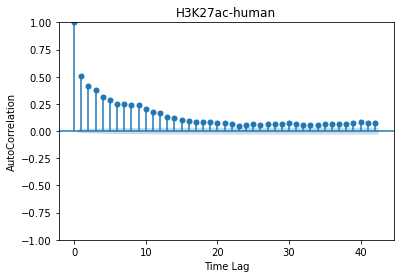

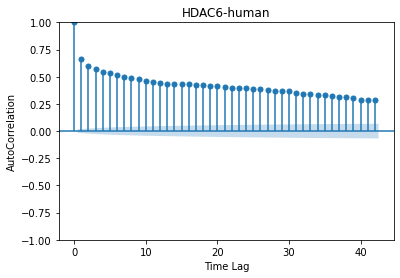

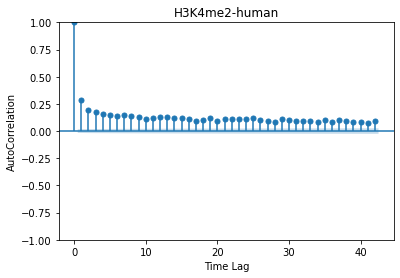

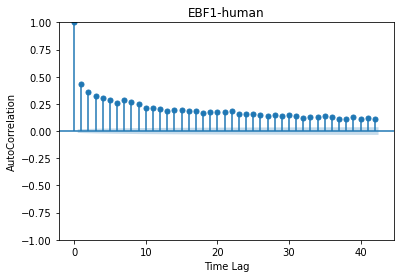

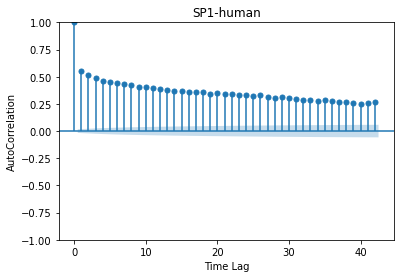

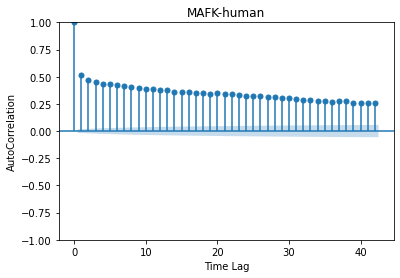

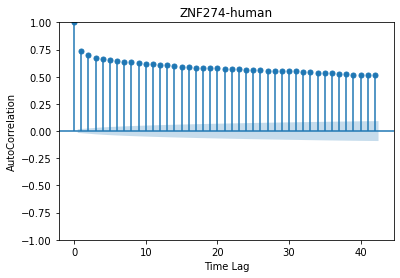

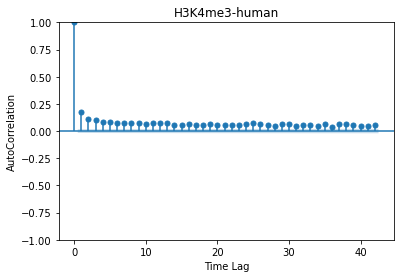

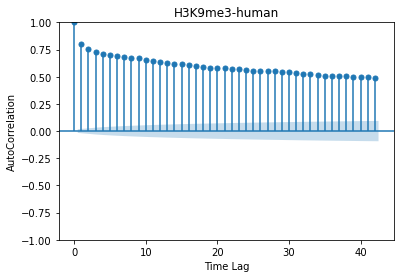

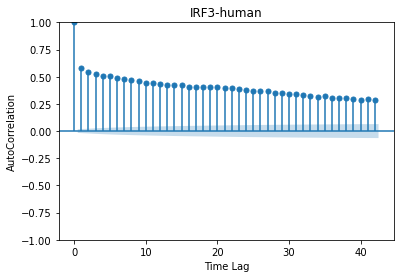

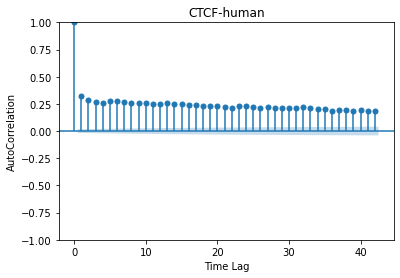

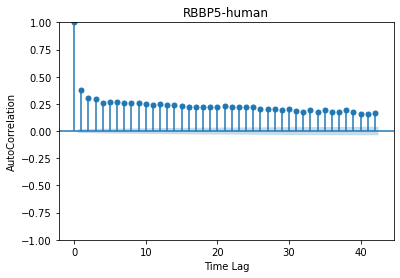

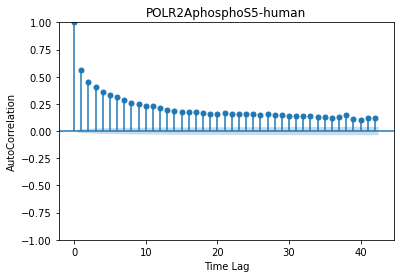

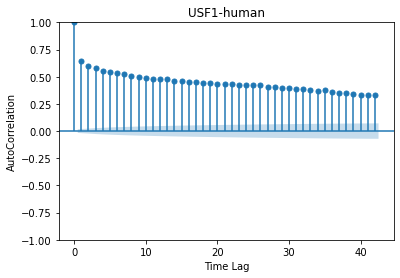

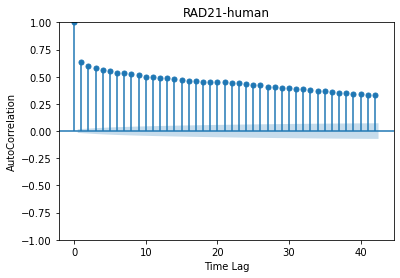

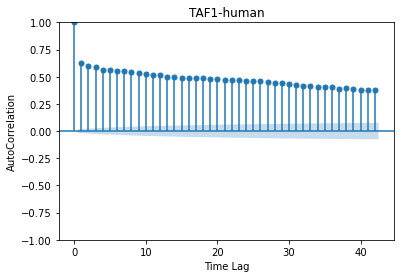

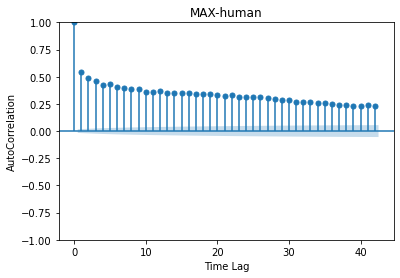

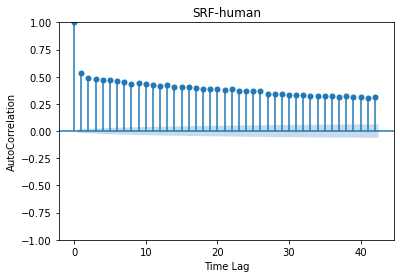

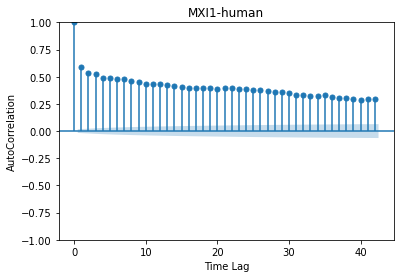

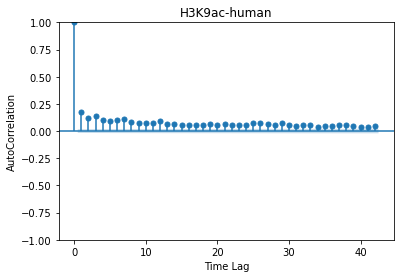

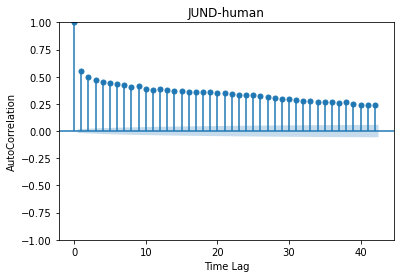

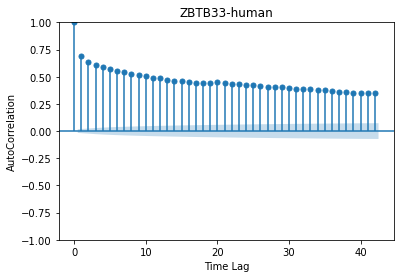

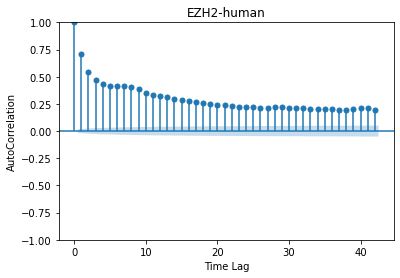

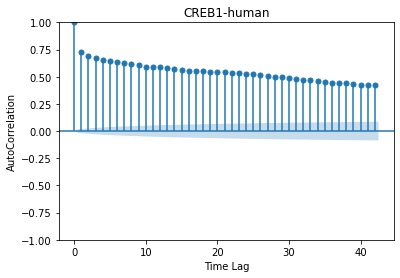

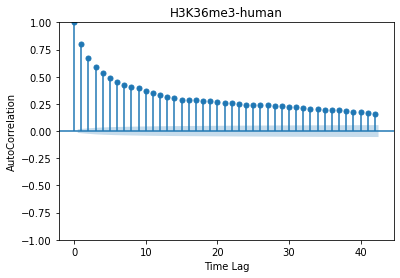

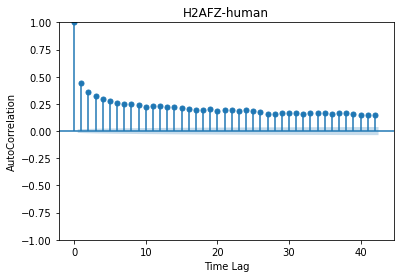

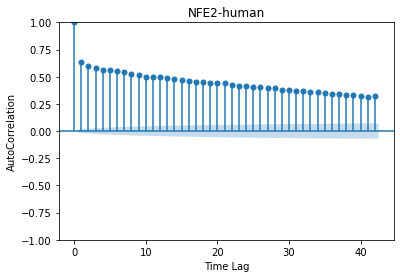

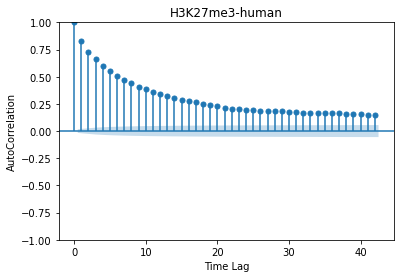

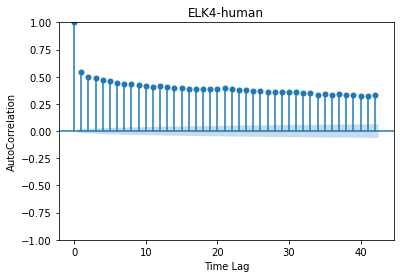

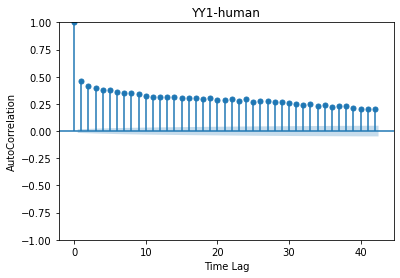

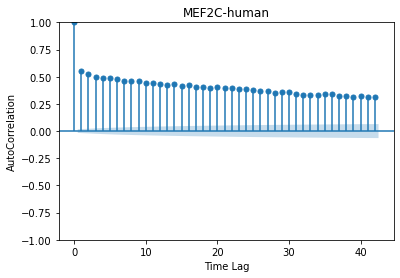

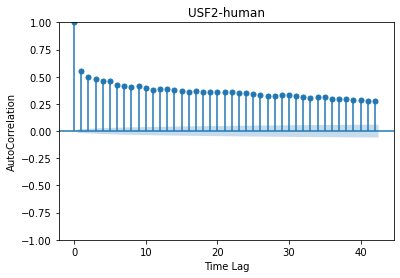

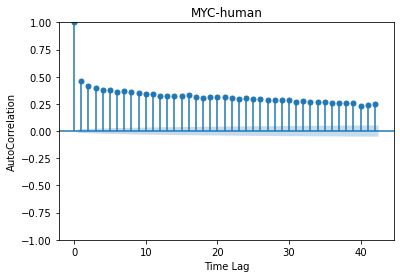

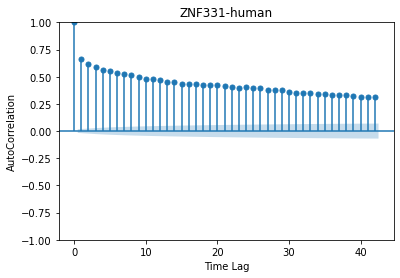

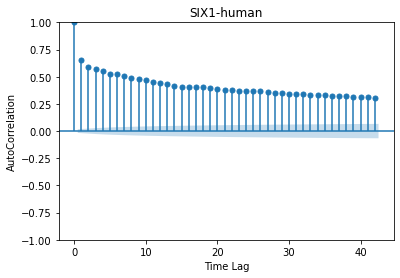

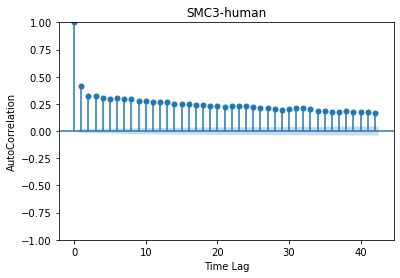

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(36):
    assay_type =  Filter[Filter['Experiment target']== (Filter['Experiment target'].unique()[i])].iloc[0, 1]
    df_assay = df.loc[:,df.columns == assay_type]
    plot_acf(df_assay)
    plt.title(Filter['Experiment target'].unique()[i])
    plt.xlabel('Time Lag')
    plt.ylabel("AutoCorrelation")
    plt.show()

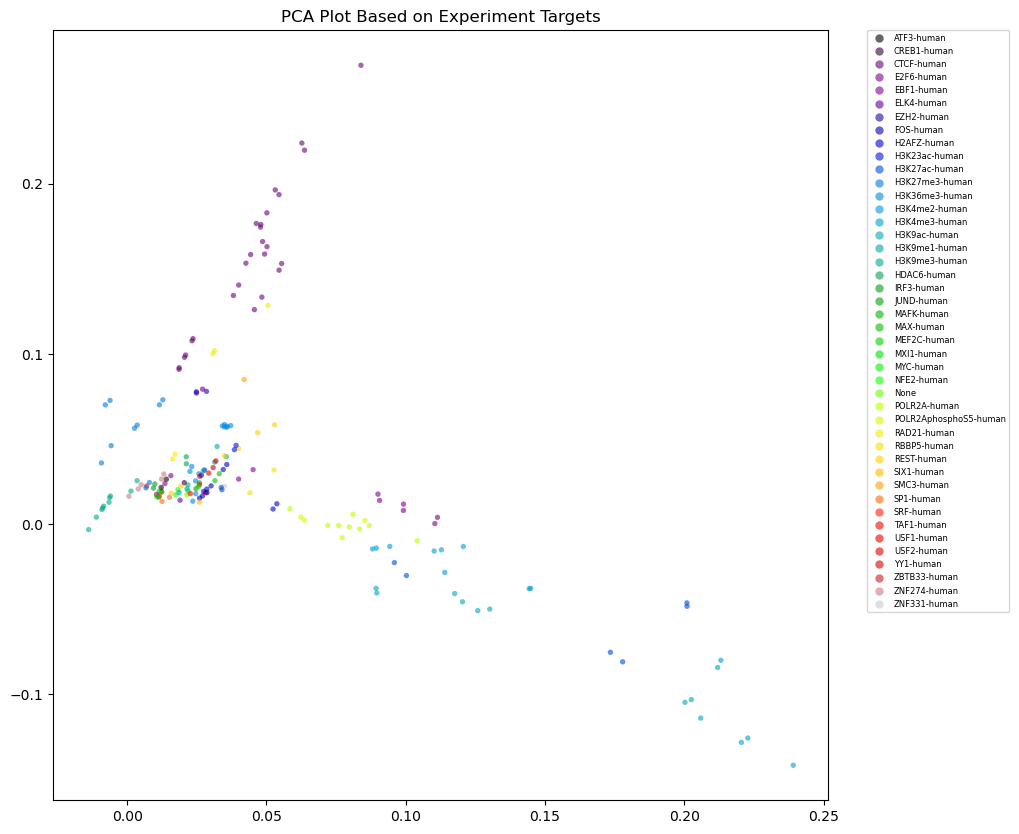

In [122]:
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Experiment target", alpha = 0.6, lw = 0, figsize=(10,10), s=15)
plt.title('PCA Plot Based on Experiment Targets')
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

Based on the line plots and autocorrelation plots above, TF ChIP-seq and Histone ChIP-seq appear to show broad patterns, while ATAC-seq shows a more narrow pattern. On the autocorrelation plot, the faster a dataset reaches its asymptote, the more narrow the pattern.

For the experiment targets, the line plots and auto-correlation plots reflect a more narrow pattern across cell types. The patterns also relate to those seen in PCA.

# Q5
- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


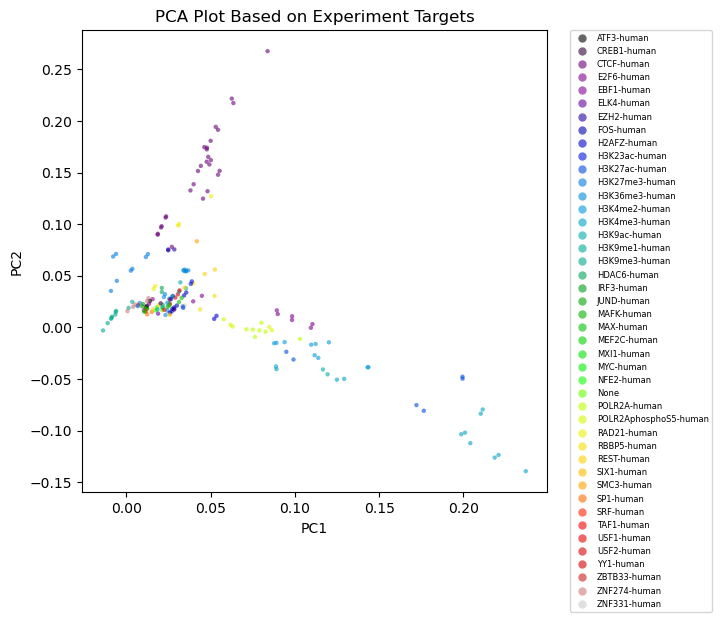

In [149]:
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Experiment target", alpha = 0.6, lw = 0, figsize=(6,6), s=10)
plt.title('PCA Plot Based on Experiment Targets')
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

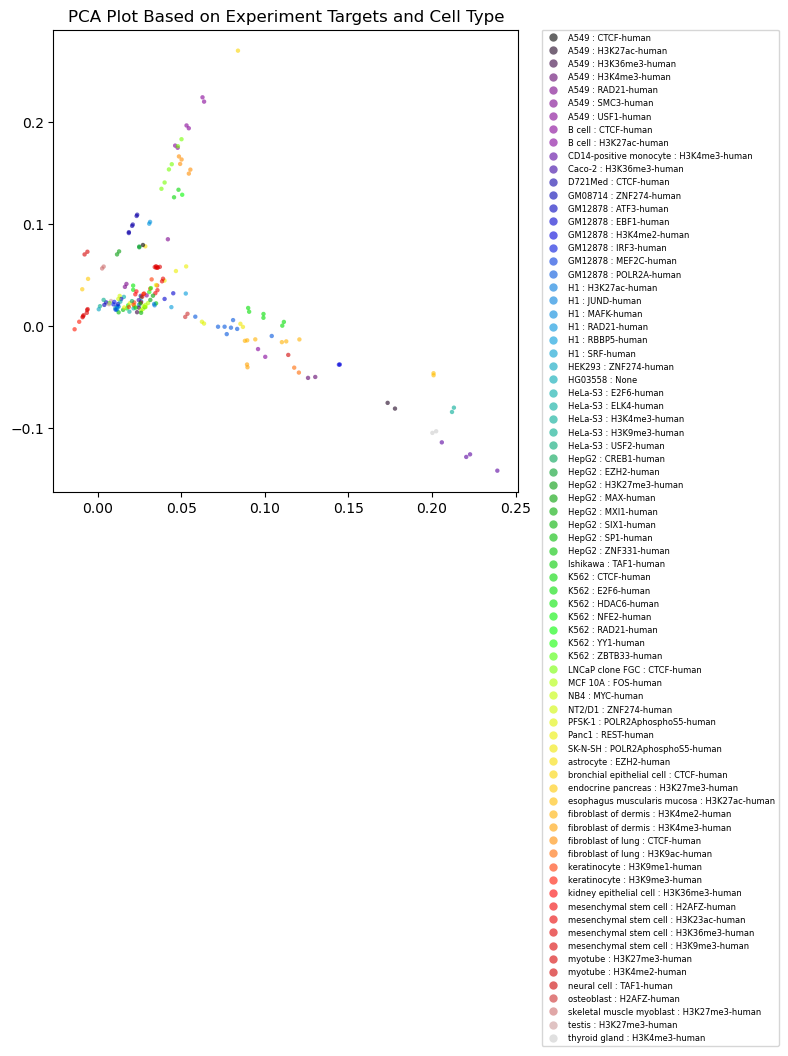

In [124]:
bigwig_metadata['Type:Target']=bigwig_metadata['Biosample term name'] +" : "+ bigwig_metadata['Experiment target']
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Type:Target", alpha = 0.6, lw = 0, figsize=(6,6), s=10)
plt.title('PCA Plot Based on Experiment Targets and Cell Type')
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

<span style="color:red">There are way too many experiments in this graph to be readable. I would suggest filtering the data a bit more to remove some of the outliers and potentially grouping some of the experiments into a single experiment if they are on similar targers like Histones or TF's to simplifiy it.</span>


The CTCF experimental targets for different cell types tend to cluster closely with other experimental targets in the PC space, and appear less centralized. This makes biological sense, as CTCF is a multifunctional gene that serves several roles in transcription regulation, including activation, repression, and insulation. It also makes sense that in each cell type, the CTCF experimental targets cluster close to each other, as their characteristics should be highly conserved.

# Q6
- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


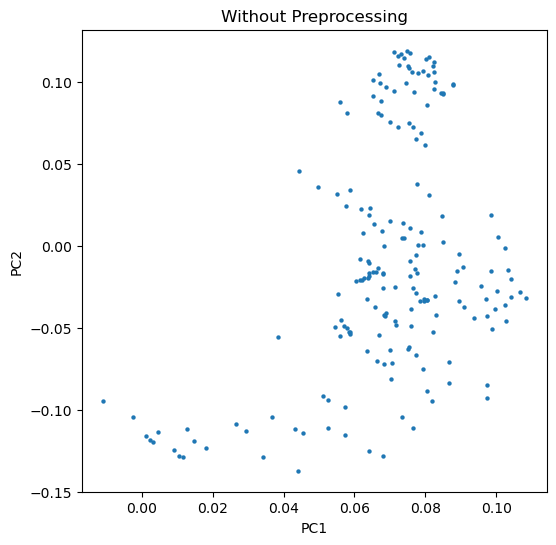

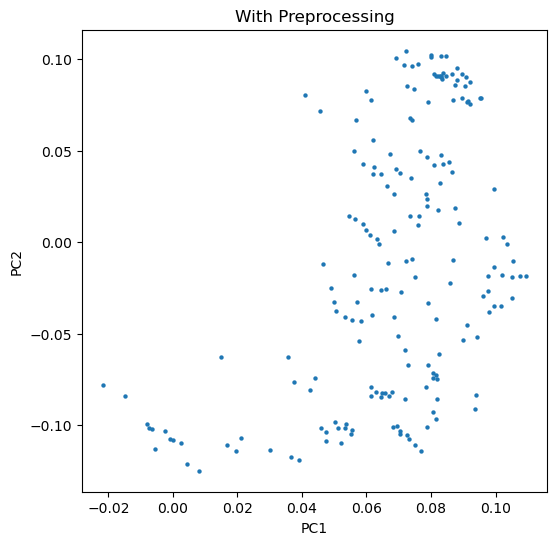

In [127]:
from sklearn.preprocessing import StandardScaler
dfx = df.drop(range(3750,4250), axis=0)

df_mod = StandardScaler().fit_transform(df.iloc[:, 3:-1])
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(df_mod)
plot_pca(pca, alpha=1, figsize=(6, 6))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Without Preprocessing")
plt.show()

df_mod = StandardScaler().fit_transform(dfx.iloc[:, 3:-1])
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(df_mod)
plot_pca(pca, alpha=1, figsize=(6,6))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('With Preprocessing')
plt.show()

We picked the range 3750-4250 to remove from the dataset since this is the definitive range which the centromere falls under. The data are more clearly distributed across the axes and appears to have less outliers using the scaler. Preprocessing does not obvious impact for this dataset in terms of PCA, but does tighten up some of the variance observed when preprocessing is not run.

<span style="color:red">It would be more useful if you did a PCA plot without the standard scaler, and a PCA with the standard scalar to see how preprocessing changes the clustering on the PCA. The plots above really just show the difference bewteen including and excluding the chr10 region with centromere which modifies the clustering a little bit but still isn't the most useful to demonstrate the point of preproccesing using Standard Scalar Fit. </span>

# Q7
- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


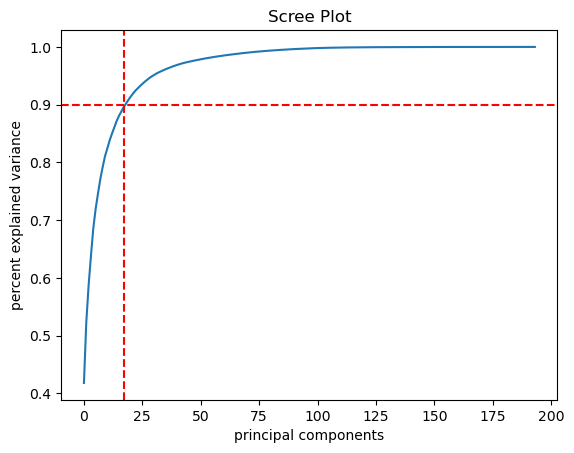

In [128]:
pca = sklearn.decomposition.PCA().fit(df.iloc[:,:])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.9, color="r", linestyle = '--')
plt.axvline(x=17, color="r", linestyle = '--')
plt.xlabel('principal components')
plt.ylabel('percent explained variance');
plt.title("Scree Plot")
plt.show()

<span style="color:red">I think we got a different number of PC's for this, but it would be helpful if you label the x-axis point on the graph so we know exactly how many PC's are needed. </span>


Around 17-18 PCs are needed to explain 90% of the variance in the data as shown by the Scree plot

# Q8
- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


In [142]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

smalldf = df.iloc[:3000,:50]
mds = MDS(random_state=0)
dft = mds.fit_transform(smalldf)

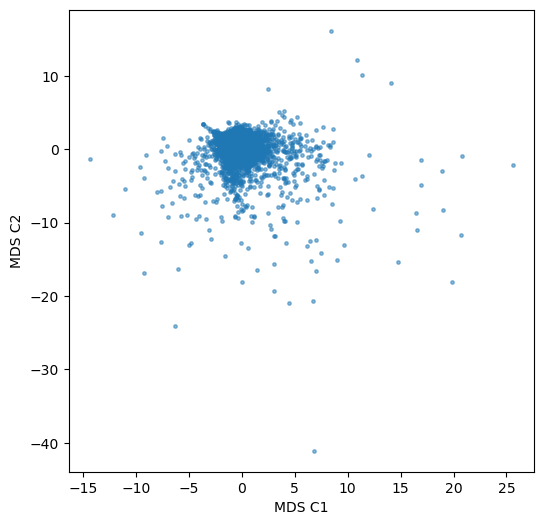

In [143]:
plt.figure(figsize=(6,6))
plt.scatter(x=dft[:,0], y=dft[:,1], alpha=0.5, s=6)
plt.xlabel('MDS C1')
plt.ylabel('MDS C2')
plt.show() 

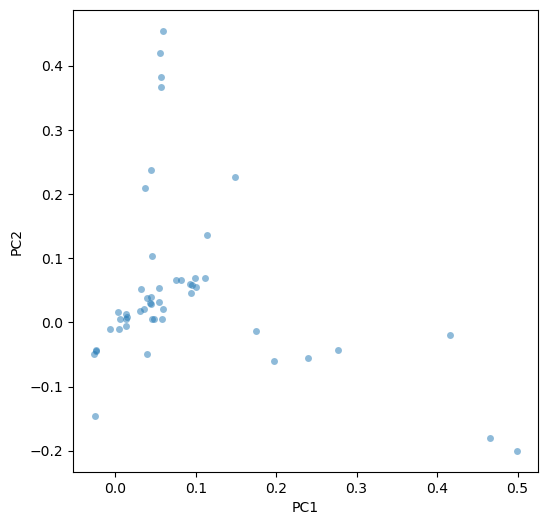

In [144]:
pca_small = PCA(n_components=2)
pca_small.fit(smalldf)
plot_pca(pca_small, alpha=0.5, s=25, figsize=(6,6))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Pairwise euclidian distance can be used to find the differences in these two methods

In [145]:
from sklearn.metrics.pairwise import euclidean_distances
pca_small=pca_small.fit_transform(smalldf)
mds_euc=euclidean_distances(dft, dft)
pca_euc=euclidean_distances(pca_small, pca_small)

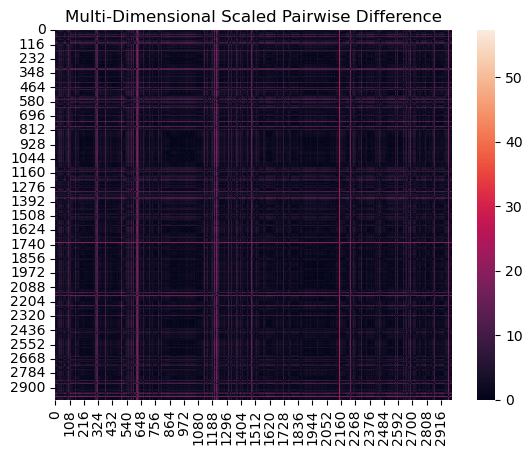

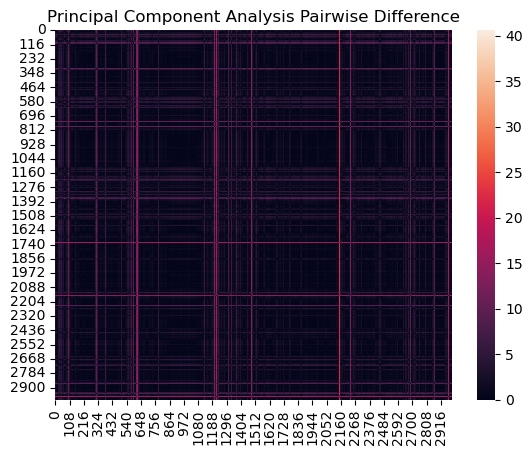

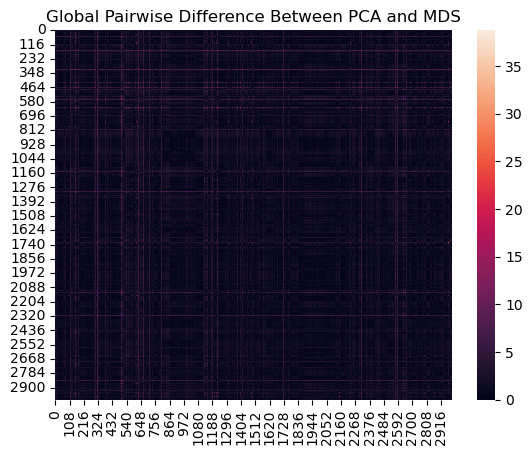

In [146]:
sns.heatmap(mds_euc)
plt.title("Multi-Dimensional Scaled Pairwise Difference")
plt.show()
sns.heatmap(pca_euc)
plt.title("Principal Component Analysis Pairwise Difference")
plt.show()
sns.heatmap(abs(mds_euc-pca_euc))
plt.title("Global Pairwise Difference Between PCA and MDS")
plt.show()

When plotting MDS and PCA on a scatter plot, their results could not look more different from each other. However, when looking at pairwise euclidian distances, the similarities between these two methods start to reveal themselves. The last heatmap shows the difference between the pairwise distances, and the patterns that show for the differences are quite low.

While the last plot shows that these two methods are quite similar, the MDS method could only be used on a small subset of the data, meaning PCA is more efficient for large datasets.

<span style="color:red">Label the axes on the heatmap so we know what we are comparing. </span>


# Q9
- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


Yes, non-negative matrix factorization could be a useful method for this dataset. While PCA has been helpful for approximating characteristics of the dataset without distinguishing which feature comes from where, NMF would allow us to take a more additive approach, in which metafeatures of our dataset better represent the characteristics of the data as a whole.